# This notebook is for the Fair-Shapely experiment

In [23]:
%reload_ext autoreload
%autoreload 2

### 1. Import libraries

In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

### 2. Import dataset

In [25]:
from src.data.unified_dataloader import load_dataset

a, processed_compas4race= load_dataset('compas4race')

In [26]:
processed_compas4race.head(3)

,sex,age,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree_F,c_charge_degree_M,type_of_assessment_Risk of Recidivism,score_text_High,score_text_Low,score_text_Medium,two_year_recid
0,1,-0.061334,1,-0.162011,-0.195526,-0.227625,-0.735792,1,0,1,0,1,0,1
1,1,-0.901239,1,-0.162011,-0.195526,1.703263,0.059694,1,0,1,0,1,0,1
2,1,-0.985229,1,-0.162011,1.785502,-0.227625,-0.536921,1,0,1,1,0,0,0


### 3. Split label/unlabel data, split train/test data.

In [27]:
'''COMPAS for race research'''
df = processed_compas4race.copy()
X = df.drop('two_year_recid', axis=1)
y = df['two_year_recid']

# into 70% training and 30% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=25) 
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')

X_train shape: (4305, 13)
X_test shape: (1845, 13)


### 4. Train the original model

In [28]:
model = XGBClassifier()  # 可以替换为 RandomForestClassifier() 等其他模型
model.fit(X_train,y_train)

# 预测和评估
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.6742547425474255


In [29]:
X_train['race'].value_counts()

race
1    2597
0    1708
Name: count, dtype: int64

In [30]:
'''把X_train分成majority和minority两个部分'''

male_condition = X_train['race'] == 1
X_train_majority = X_train[male_condition]
y_train_majority = y_train[male_condition]

female_condition = X_train['race'] == 0
X_train_minority = X_train[female_condition]
y_train_minority = y_train[female_condition]

### 5. Evaluate the performance of original model

In [31]:
from src.attribution.oracle_metric import perturb_numpy_ver
from src.attribution import FairnessExplainer
sen_att_name = ["race"]
sen_att = [X_train.columns.get_loc(name) for name in sen_att_name]
priv_val = [1]
unpriv_dict = [list(set(X_train.values[:, sa])) for sa in sen_att]
for sa_list, pv in zip(unpriv_dict, priv_val):
    sa_list.remove(pv)
# print(f'sen_att_name:{sen_att_name}')
# print(f'sen_att:{sen_att}') # index of sensitive attribute
# print(f'priv_val:{priv_val}') # privileged value
# print(f'unpriv_dict:{unpriv_dict}') # unprivileged value(all values in the sensitive attribute, except the privileged value)



''' 
计算DR value的函数
'''
def fairness_value_function(sen_att, priv_val, unpriv_dict, X, model):
    X_disturbed = perturb_numpy_ver(
        X=X,
        sen_att=sen_att,
        priv_val=priv_val,
        unpriv_dict=unpriv_dict,
        ratio=1.0,
    )
    fx = model.predict_proba(X)[:, 1]
    fx_q = model.predict_proba(X_disturbed)[:, 1]
    return np.mean(np.abs(fx - fx_q))
original_test_DR = fairness_value_function(sen_att, priv_val, unpriv_dict, X_test.values, model)
print(f'original_test_DR: {original_test_DR}')
original_train_DR = fairness_value_function(sen_att, priv_val, unpriv_dict, X_train.values, model)
print(f'original_train_DR: {original_train_DR}')

original_test_DR: 0.09175542742013931
original_train_DR: 0.09234681725502014


### 5. 把female和male匹配，（或者male和female匹配），然后进行修改，重新训练

2. 初始化FairnessExplainer
--------接下来先对minority group进行修改--------
3(a). 将X_train_minority_label0与X_train_majority_label0进行匹配
3(b). 将X_train_minority_label1与X_train_majority_label1进行匹配
4(a). 使用fairshap, 从 X_train_majority_label0中找到合适的值替换X_train_minority_label0中的数据
4(b). 使用fairshap, 从 X_train_majority_label1中找到合适的值替换X_train_minority_label1中的数据
5. 计算出varphi和q
在X_train_minority中shapely value中大于0.1的值的个数有: 124
--------接下来对majority group进行修改--------
3(a). 将X_train_majority_label0与X_train_minority_label0进行匹配
3(b). 将X_train_majority_label1与X_train_minority_label1进行匹配
4(a). 使用fairshap, 从 X_train_minority_label0中找到合适的值替换X_train_majority_label0中的数据
4(b). 使用fairshap, 从 X_train_minority_label1中找到合适的值替换X_train_majority_label1中的数据
5. 计算出varphi和q
在X_train_majority中shapely value中大于0.1的值的个数有: 247
6. 开始整理minority部分的修改和majority部分的修改并且合并新数据,共修改371个数据点, 使用new training set训练新模型
changed_value_info.shape: 0


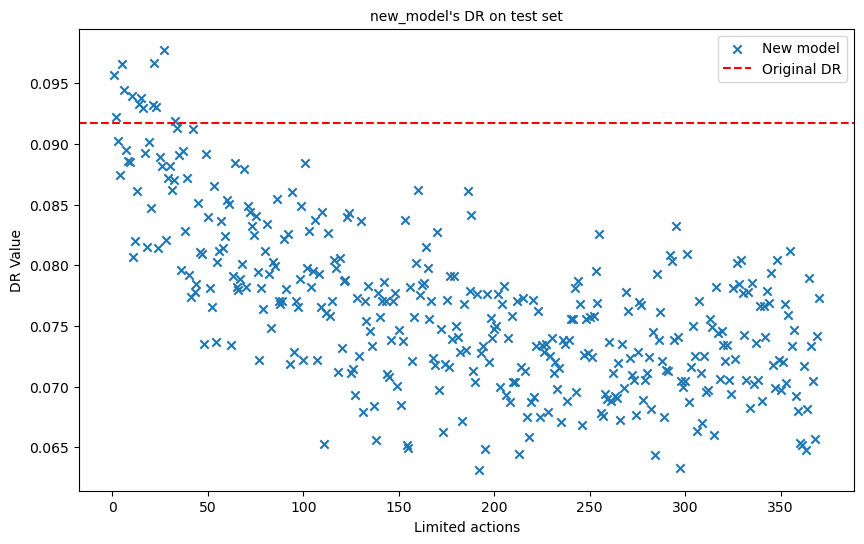

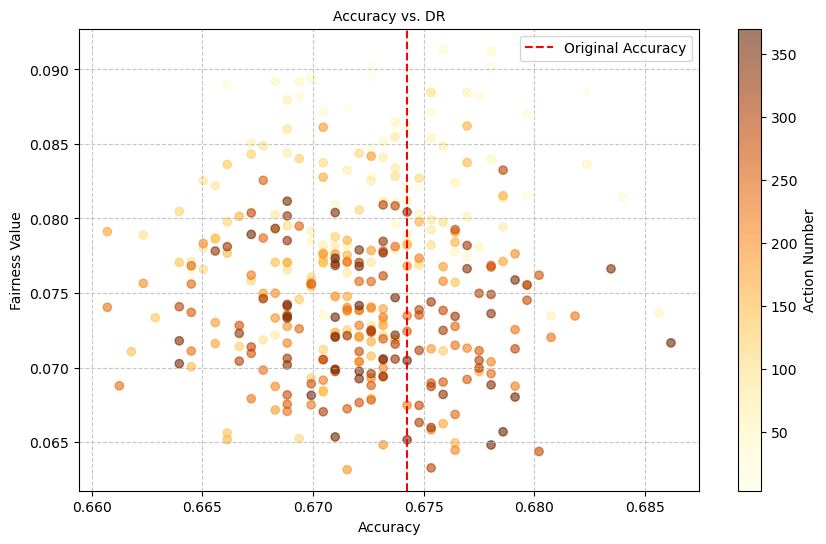

([0.095690094,
  0.0922575,
  0.09024928,
  0.087419964,
  0.09661437,
  0.09445426,
  0.08952994,
  0.08863004,
  0.088478655,
  0.09394279,
  0.08066071,
  0.08197875,
  0.086138815,
  0.09333022,
  0.09377284,
  0.092969775,
  0.0892687,
  0.08151089,
  0.09016225,
  0.08475244,
  0.093190596,
  0.096706145,
  0.09307847,
  0.08141917,
  0.088954896,
  0.088202566,
  0.0977724,
  0.08210102,
  0.0871597,
  0.08818244,
  0.08619768,
  0.087008774,
  0.09186992,
  0.091324225,
  0.08913202,
  0.07961172,
  0.08939867,
  0.08281169,
  0.087185666,
  0.07923738,
  0.07742044,
  0.09124134,
  0.07778355,
  0.0784596,
  0.08517069,
  0.08112475,
  0.08091086,
  0.07351585,
  0.08918357,
  0.083969116,
  0.07809769,
  0.076565646,
  0.08651124,
  0.073655024,
  0.08029958,
  0.081181206,
  0.08362656,
  0.08140265,
  0.0823938,
  0.08537725,
  0.08504697,
  0.073459655,
  0.07914802,
  0.08843476,
  0.078211166,
  0.0779218,
  0.078902125,
  0.080106065,
  0.08794637,
  0.07819511,
  0.084

In [32]:

from src.experiments_approach4 import ExperimentNew4
''' 改变minority group中的部分特征值'''

experiment = ExperimentNew4(
                            model,
                            X_train_majority,
                            y_train_majority,
                            X_train_minority,
                            y_train_minority,
                            X_test,
                            y_test,
                            dataset_name='compas4race')
experiment.run_experiment()


2. 初始化FairnessExplainer
3(a). 将X_train_majority_label0与X_train_minority_label0进行匹配
3(b). 将X_train_majority_label1与X_train_minority_label1进行匹配
4(a). 使用fairshap, 从 X_train_minority_label0中找到合适的值替换X_train_majority_label0中的数据
4(b). 使用fairshap, 从 X_train_minority_label1中找到合适的值替换X_train_majority_label1中的数据
5. 计算出varphi和q
shapely value中大于0.1的值的个数有: 84
shapely value中大于0.1的值的个数有: 125


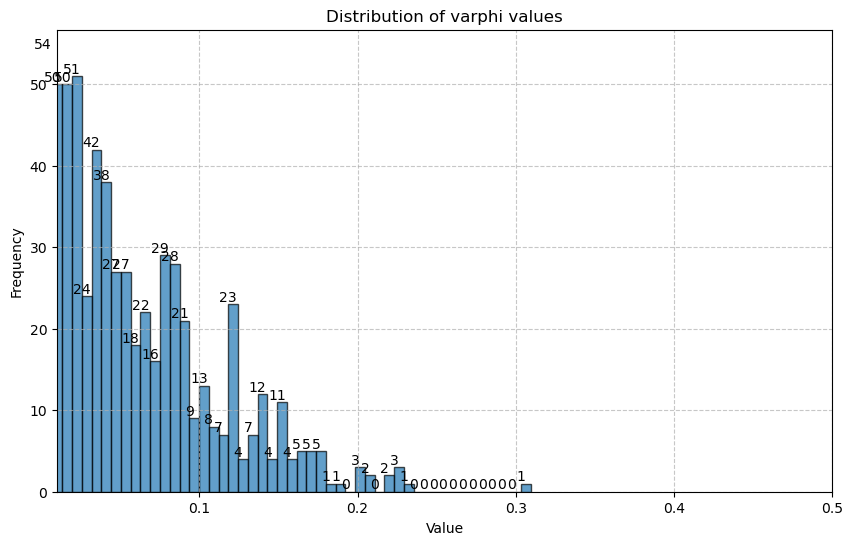

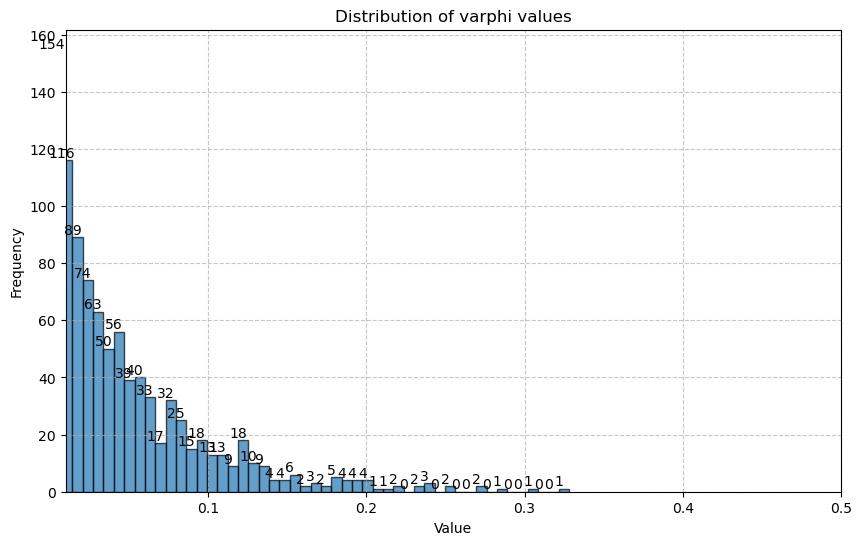

6. 开始整理并且合并新数据,共修改209个数据点, 使用new training set训练新模型
changed_value_info.shape: 208


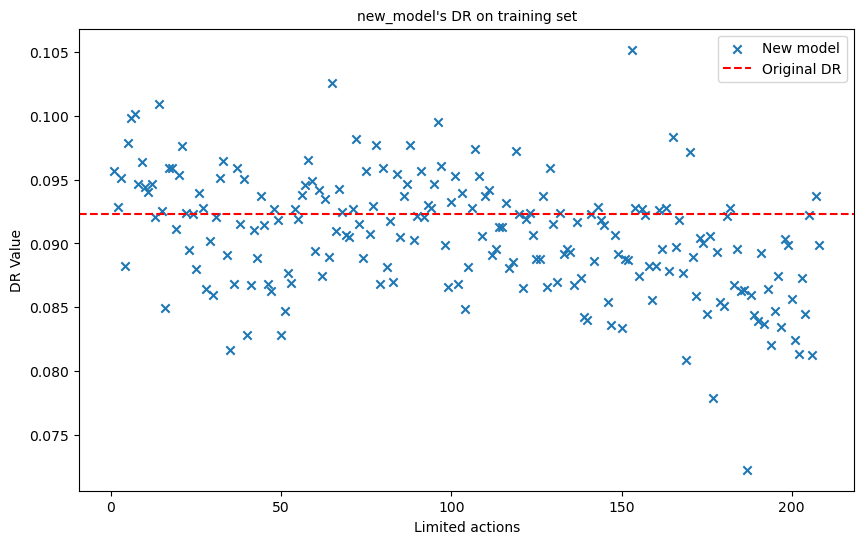

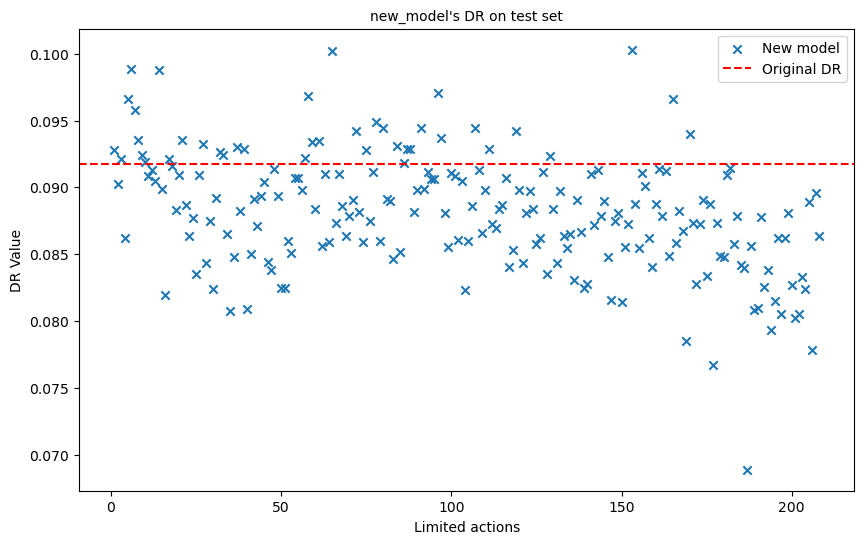

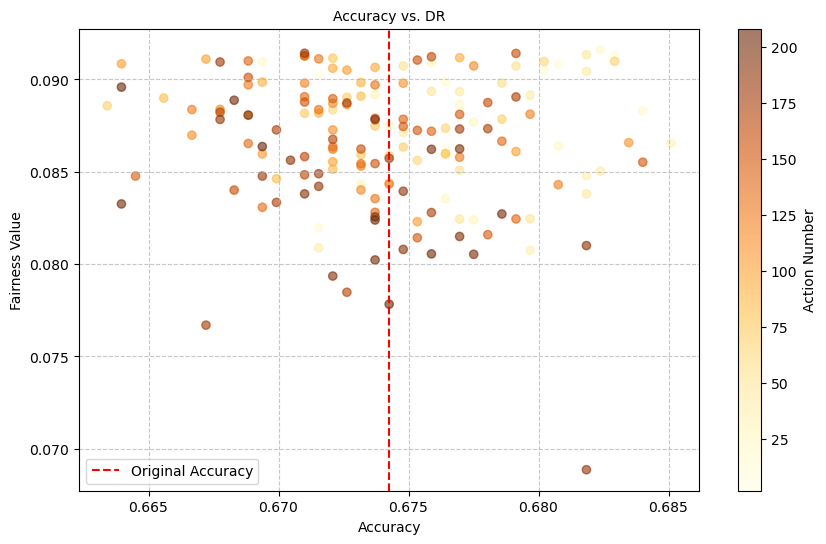

([0.09281369,
  0.09028161,
  0.092152126,
  0.086217724,
  0.09660487,
  0.098847985,
  0.09576711,
  0.09351697,
  0.09239669,
  0.091928735,
  0.09083409,
  0.09130313,
  0.090499856,
  0.09882089,
  0.08989074,
  0.081963286,
  0.092150666,
  0.091608614,
  0.088299155,
  0.090957634,
  0.093533516,
  0.088646404,
  0.08639275,
  0.08770125,
  0.08353775,
  0.09090368,
  0.09324173,
  0.08433767,
  0.08749694,
  0.08239632,
  0.089182205,
  0.09265275,
  0.09243171,
  0.08654264,
  0.08074368,
  0.08479513,
  0.09304905,
  0.08826981,
  0.092867374,
  0.080882154,
  0.085037336,
  0.08915069,
  0.08712827,
  0.08933806,
  0.09042676,
  0.08440347,
  0.08380931,
  0.09134141,
  0.089353964,
  0.082437165,
  0.08245596,
  0.08595473,
  0.08509433,
  0.09072494,
  0.09073167,
  0.08980344,
  0.092178226,
  0.09685765,
  0.09337671,
  0.088353485,
  0.093444906,
  0.08561556,
  0.09097095,
  0.08588482,
  0.10018296,
  0.0873595,
  0.09098218,
  0.08857277,
  0.086343594,
  0.08785048,

In [22]:
''' 改变majority group中的部分特征值'''
experiment2 = ExperimentNew2(
                            model,
                            X_train_majority,
                            y_train_majority,
                            X_train_minority,
                            y_train_minority,
                            X_test,
                            y_test,
                            dataset_name='compas4race',
                            change_group = 'majority')
experiment2.run_experiment()